In [2]:
monitor='val_accuracy'
epochs=150
batch_size=32
input_shape=(224, 224, 3) # please resize it to (224,224,3) if you have enough RAM
Verbose=True

In [10]:
import sys
print("Python version:", sys.version)

import skimage
print('skimage:',  skimage.__version__)

import tensorflow as tf
print('Tensorflow:',tf.__version__)

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

import multiprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

Python version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
skimage: 0.21.0
Tensorflow: 2.13.0


In [4]:
#apt-get install git python3-opencv
import os

if not os.path.isdir('k'):
  !git clone https://github.com/hamidpeywasti/keras-neural-api k
else:
  !cd k && git pull

!cd k && pip install .

!rm -rf k

import cai
import cai.datasets
import cai.models
import cai.inception_v3
import cai.layers
import cai.util
from cai.layers import conv2d_bn

Cloning into 'k'...
remote: Enumerating objects: 1807, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 1807 (delta 135), reused 147 (delta 72), pack-reused 1588
Receiving objects: 100% (1807/1807), 15.69 MiB | 22.25 MiB/s, done.
Resolving deltas: 100% (1248/1248), done.
Processing /kaggle/working/k
  Preparing metadata (setup.py) ... done
  Created wheel for cai: filename=cai-0.1.7-py3-none-any.whl size=61387 sha256=d25bbed7d23e758e813e04f9267949dd2036e29900cf98296e4df05a68b65e5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-4l8q5ld6/wheels/7f/63/1a/ed2b6234f76aae55efe76492246448486e41178bd0b5682ecf
Successfully built cai


In [5]:
def two_path5_inception_v3(
    include_top=True,
    weights=None, #'two_paths_plant_leafs'
    input_shape=(224,224,3),
    pooling=None,
    classes=1000,
    two_paths=False,
    deep_two_paths=False,                
    deep_two_paths_compression=0.655,
    deep_two_paths_bottleneck_compression=0.5,
    l_ratio=0.5,
    ab_ratio=0.5,
    max_mix_idx=10,
    max_mix_deep_two_paths_idx=-1,
    model_name='two_path_inception_v3',
    kType=0,
    **kwargs
):
    """
    Instantiates the Inception v3 architecture with 2 paths options.
    """
    img_input = keras.layers.Input(shape=input_shape)
    if (deep_two_paths):  max_mix_deep_two_paths_idx = max_mix_idx

    if keras.backend.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    

    if two_paths:
        if (l_ratio>0):
            l_branch = cai.layers.CopyChannels(0,1)(img_input)
            l_branch = conv2d_bn(l_branch, int(round(32*l_ratio)), 3, 3, strides=(2, 2), padding='valid')
            l_branch = conv2d_bn(l_branch, int(round(32*l_ratio)), 3, 3, padding='valid')
            l_branch = conv2d_bn(l_branch, int(round(64*l_ratio)), 3, 3)
            l_branch = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(l_branch)
            
            #l_branch    = conv2d_bn(x, int(round(80*deep_two_paths_bottleneck_compression)), 1, 1, padding='valid', name='second_block_ta', activation=None, has_batch_norm=True)
            l_branch    = cai.inception_v3.create_inception_path(last_tensor=l_branch, compression=deep_two_paths_bottleneck_compression, channel_axis=channel_axis, name='second_block_ta', activation=None, has_batch_norm=True, kType=kType)        
            # l_branch    = conv2d_bn(l_branch,    int(round(80 *deep_two_paths_compression)), 1, 1, padding='valid')
            l_branch = cai.inception_v3.kInceptionPointwise(l_branch, filters=int(round(80 *l_ratio)), name='l_branch_path', kType=kType)
            l_branch    = conv2d_bn(l_branch,    int(round(192*l_ratio)), 3, 3, padding='valid')

        if (ab_ratio>0):
            ab_branch = cai.layers.CopyChannels(1,2)(img_input)
            ab_branch = conv2d_bn(ab_branch, int(round(32*ab_ratio)), 3, 3, strides=(2, 2), padding='valid')
            ab_branch = conv2d_bn(ab_branch, int(round(32*ab_ratio)), 3, 3, padding='valid')
            ab_branch = conv2d_bn(ab_branch, int(round(64*ab_ratio)), 3, 3)
            ab_branch = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(ab_branch)
            
            #ab_branch = conv2d_bn(x, int(round(80*deep_two_paths_bottleneck_compression)), 1, 1, padding='valid', name='second_block_tb', activation=None, has_batch_norm=True)        
            ab_branch = cai.inception_v3.create_inception_path(last_tensor=ab_branch, compression=deep_two_paths_bottleneck_compression, channel_axis=channel_axis, name='second_block_tb', activation=None, has_batch_norm=True, kType=kType)
            # ab_branch = conv2d_bn(ab_branch, int(round(80 *deep_two_paths_compression)), 1, 1, padding='valid')
            ab_branch = cai.inception_v3.kInceptionPointwise(ab_branch, filters=int(round(80 *ab_ratio)), name='ab_branch_path', kType=kType)
            ab_branch = conv2d_bn(ab_branch, int(round(192*ab_ratio)), 3, 3, padding='valid')

        if (l_ratio>0):
            if (ab_ratio>0):
                x = keras.layers.Concatenate(axis=channel_axis, name='concat_first_block')([l_branch, ab_branch])
            else:
                x = l_branch
        else:
            x = ab_branch
        
    else:
        single_branch = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
        single_branch = conv2d_bn(single_branch, 32, 3, 3, padding='valid')
        single_branch = conv2d_bn(single_branch, 64, 3, 3)
        single_branch = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(single_branch)
        
        # x = conv2d_bn(x, 80, 1, 1, padding='valid')
        single_branch= cai.inception_v3.kInceptionPointwise(single_branch, filters=80, name='single_path', kType=kType)
        x = conv2d_bn(single_branch, 192, 3, 3, padding='valid')

          
    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    if max_mix_idx >= 0:
        for id_layer in range(max_mix_idx+1):
            if (max_mix_deep_two_paths_idx >= id_layer):
                x = cai.inception_v3.create_inception_v3_two_path_mixed_layer(x,  id=id_layer,  name='mixed'+str(id_layer),
                    channel_axis=channel_axis, bottleneck_compression=deep_two_paths_bottleneck_compression, 
                    compression=deep_two_paths_compression, has_batch_norm=True, kType=kType)
            else:
                x = cai.inception_v3.create_inception_v3_mixed_layer(x,  id=id_layer,  name='mixed'+str(id_layer), channel_axis=channel_axis, kType=kType)
    
    if include_top:
        # Classification block
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = keras.layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = keras.layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = keras.layers.GlobalMaxPooling2D()(x)

    inputs = img_input
    # Create model.
    model = keras.models.Model(inputs, x, name=model_name)
    return model

def plot_history(filename):
    plt.figure(figsize=(10, 6)) 

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.ylim(ymin=0, ymax=1.5)

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')    
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.savefig(filename)

    plt.tight_layout()
    plt.show()

# Loading Data

In [7]:
data_dir = "/kaggle/input/apple-leaf-diseases-13-classes"

label_of_classes = os.listdir(data_dir)
print("Classes Lables:", label_of_classes)

number_of_classes = len(label_of_classes)
print("Number of Classes:", number_of_classes)

train_x, val_x, test_x, train_y, val_y, test_y, classweight, classes = cai.datasets.load_images_from_folders(
    seed=7,
    root_dir=data_dir,
    lab=True,
    verbose=Verbose,
    bipolar=False,
    base_model_name='apple13_leaf',
    training_size=0.6,
    validation_size=0.2,
    test_size=0.2,
    target_size=(input_shape[0],input_shape[1]),
    has_training=True,
    has_validation=True,
    has_testing=True,
    smart_resize=True
)

print(train_x.shape,val_x.shape,test_x.shape)
print(train_y.shape,val_y.shape,test_y.shape)

Loading  13  classes.
smart resize is enabled.
loading train images
train shape is: (3516, 224, 224, 3)
loading validation images
validation shape is: (1171, 224, 224, 3)
loading test images
test shape is: (1180, 224, 224, 3)
Channel  0  min: 0.0  max: 1.0
Channel  1  min: 0.0  max: 0.8897463
Channel  2  min: 0.0  max: 0.9676888
Loaded.


# Fitting Model for L_ratio and AB_ratio

Running: Apple13-2Path5-LAB-m4-0.0
Epoch 1/120
110/110 [==============================] - ETA: 0s - loss: 1.0408 - accuracy: 0.6197
Epoch 1: val_accuracy improved from -inf to 0.06661, saving model to Apple13-2Path5-LAB-m4-0.0-best_result.hdf5
110/110 [==============================] - 19s 115ms/step - loss: 1.0408 - accuracy: 0.6197 - val_loss: 4.2111 - val_accuracy: 0.0666
Epoch 2/120
110/110 [==============================] - ETA: 0s - loss: 0.6864 - accuracy: 0.7460
Epoch 2: val_accuracy improved from 0.06661 to 0.14176, saving model to Apple13-2Path5-LAB-m4-0.0-best_result.hdf5
110/110 [==============================] - 10s 95ms/step - loss: 0.6864 - accuracy: 0.7460 - val_loss: 4.6341 - val_accuracy: 0.1418
Epoch 3/120
110/110 [==============================] - ETA: 0s - loss: 0.4890 - accuracy: 0.8259
Epoch 3: val_accuracy improved from 0.14176 to 0.23911, saving model to Apple13-2Path5-LAB-m4-0.0-best_result.hdf5
110/110 [==============================] - 10s 95ms/step - loss: 

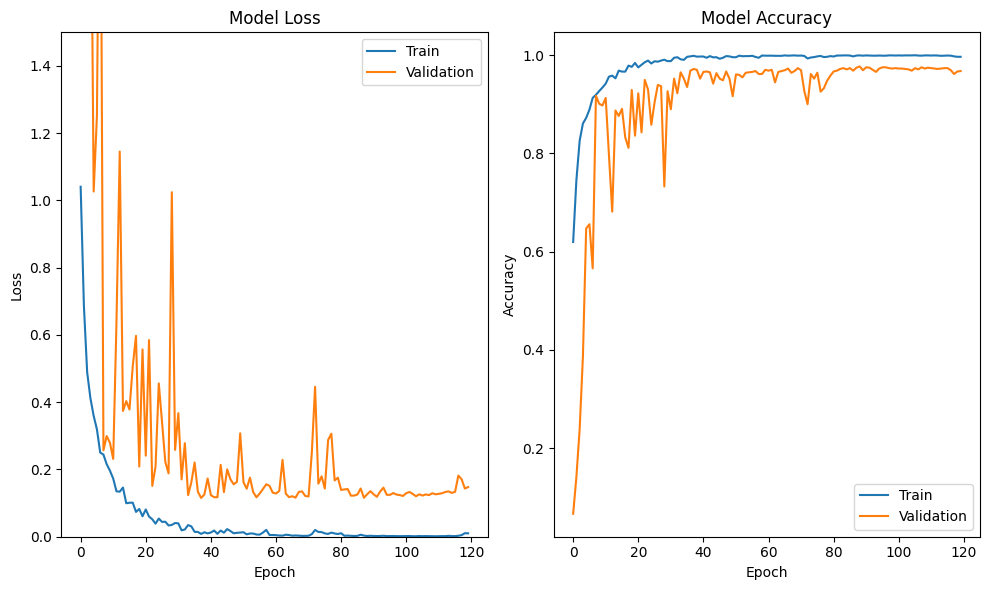

Testing Last Model: Apple13-2Path5-LAB-m4-0.0
37/37 [==============================] - 1s 29ms/step - loss: 0.1878 - accuracy: 0.9559
loss 0.18779902160167694
acc 0.9559321999549866
Best Model Results: Apple13-2Path5-LAB-m4-0.0
37/37 [==============================] - 2s 28ms/step - loss: 0.1602 - accuracy: 0.9602
loss 0.1601623147726059
acc 0.9601694941520691
Finished: Apple13-2Path5-LAB-m4-0.0
Running: Apple13-2Path5-LAB-m4-0.25
Epoch 1/120
110/110 [==============================] - ETA: 0s - loss: 0.9238 - accuracy: 0.6792
Epoch 1: val_accuracy improved from -inf to 0.10333, saving model to Apple13-2Path5-LAB-m4-0.25-best_result.hdf5
110/110 [==============================] - 20s 119ms/step - loss: 0.9238 - accuracy: 0.6792 - val_loss: 3.3014 - val_accuracy: 0.1033
Epoch 2/120
110/110 [==============================] - ETA: 0s - loss: 0.5465 - accuracy: 0.8026
Epoch 2: val_accuracy improved from 0.10333 to 0.15457, saving model to Apple13-2Path5-LAB-m4-0.25-best_result.hdf5
110/110 

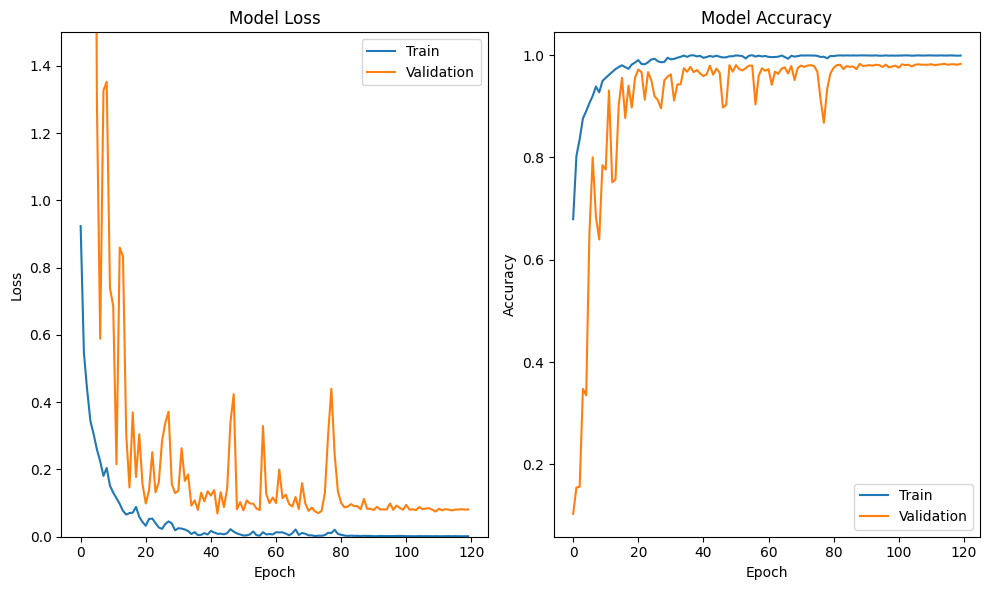

Testing Last Model: Apple13-2Path5-LAB-m4-0.25
37/37 [==============================] - 1s 29ms/step - loss: 0.1352 - accuracy: 0.9703
loss 0.13522805273532867
acc 0.9703390002250671
Best Model Results: Apple13-2Path5-LAB-m4-0.25
37/37 [==============================] - 2s 30ms/step - loss: 0.1227 - accuracy: 0.9746
loss 0.12273579090833664
acc 0.9745762944221497
Finished: Apple13-2Path5-LAB-m4-0.25
Running: Apple13-2Path5-LAB-m4-0.5
Epoch 1/120
110/110 [==============================] - ETA: 0s - loss: 0.9408 - accuracy: 0.6630
Epoch 1: val_accuracy improved from -inf to 0.07515, saving model to Apple13-2Path5-LAB-m4-0.5-best_result.hdf5
110/110 [==============================] - 20s 119ms/step - loss: 0.9408 - accuracy: 0.6630 - val_loss: 4.0247 - val_accuracy: 0.0751
Epoch 2/120
110/110 [==============================] - ETA: 0s - loss: 0.5572 - accuracy: 0.7961
Epoch 2: val_accuracy improved from 0.07515 to 0.09991, saving model to Apple13-2Path5-LAB-m4-0.5-best_result.hdf5
110/110

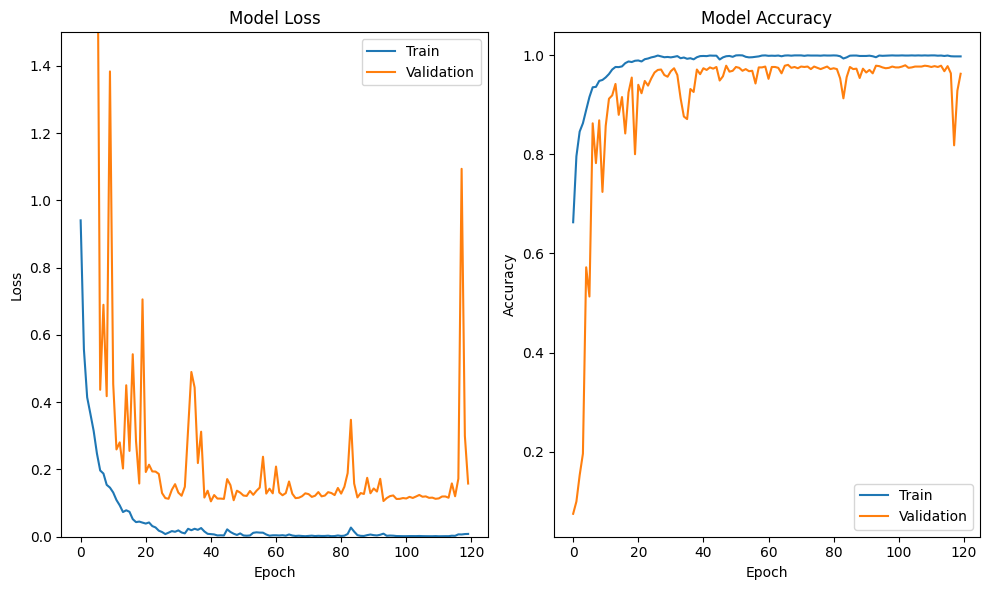

Testing Last Model: Apple13-2Path5-LAB-m4-0.5
37/37 [==============================] - 1s 29ms/step - loss: 0.2068 - accuracy: 0.9551
loss 0.20677292346954346
acc 0.9550847411155701
Best Model Results: Apple13-2Path5-LAB-m4-0.5
37/37 [==============================] - 2s 29ms/step - loss: 0.1280 - accuracy: 0.9678
loss 0.12803009152412415
acc 0.9677966237068176
Finished: Apple13-2Path5-LAB-m4-0.5
Running: Apple13-2Path5-LAB-m4-0.75
Epoch 1/120
110/110 [==============================] - ETA: 0s - loss: 0.9181 - accuracy: 0.6743
Epoch 1: val_accuracy improved from -inf to 0.07515, saving model to Apple13-2Path5-LAB-m4-0.75-best_result.hdf5
110/110 [==============================] - 21s 120ms/step - loss: 0.9181 - accuracy: 0.6743 - val_loss: 4.2405 - val_accuracy: 0.0751
Epoch 2/120
110/110 [==============================] - ETA: 0s - loss: 0.5395 - accuracy: 0.8038
Epoch 2: val_accuracy improved from 0.07515 to 0.07771, saving model to Apple13-2Path5-LAB-m4-0.75-best_result.hdf5
110/110

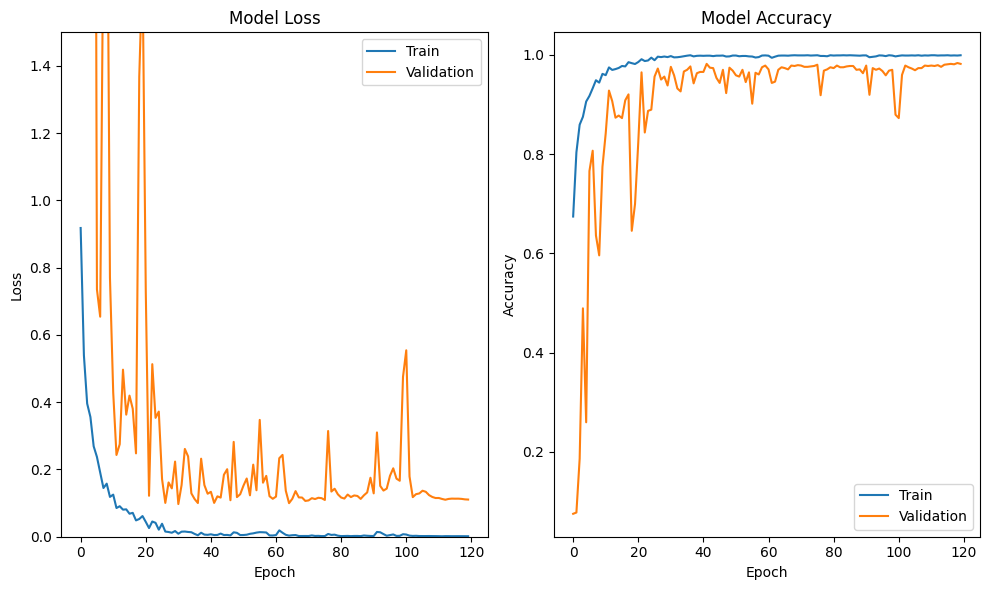

Testing Last Model: Apple13-2Path5-LAB-m4-0.75
37/37 [==============================] - 1s 30ms/step - loss: 0.1166 - accuracy: 0.9737
loss 0.11658665537834167
acc 0.9737288355827332
Best Model Results: Apple13-2Path5-LAB-m4-0.75
37/37 [==============================] - 2s 30ms/step - loss: 0.1148 - accuracy: 0.9746
loss 0.11482984572649002
acc 0.9745762944221497
Finished: Apple13-2Path5-LAB-m4-0.75
Running: Apple13-2Path5-LAB-m4-1.0
Epoch 1/120
110/110 [==============================] - ETA: 0s - loss: 1.1722 - accuracy: 0.5714
Epoch 1: val_accuracy improved from -inf to 0.06576, saving model to Apple13-2Path5-LAB-m4-1.0-best_result.hdf5
110/110 [==============================] - 19s 115ms/step - loss: 1.1722 - accuracy: 0.5714 - val_loss: 4.1459 - val_accuracy: 0.0658
Epoch 2/120
110/110 [==============================] - ETA: 0s - loss: 0.7575 - accuracy: 0.7156
Epoch 2: val_accuracy did not improve from 0.06576
110/110 [==============================] - 10s 92ms/step - loss: 0.7575

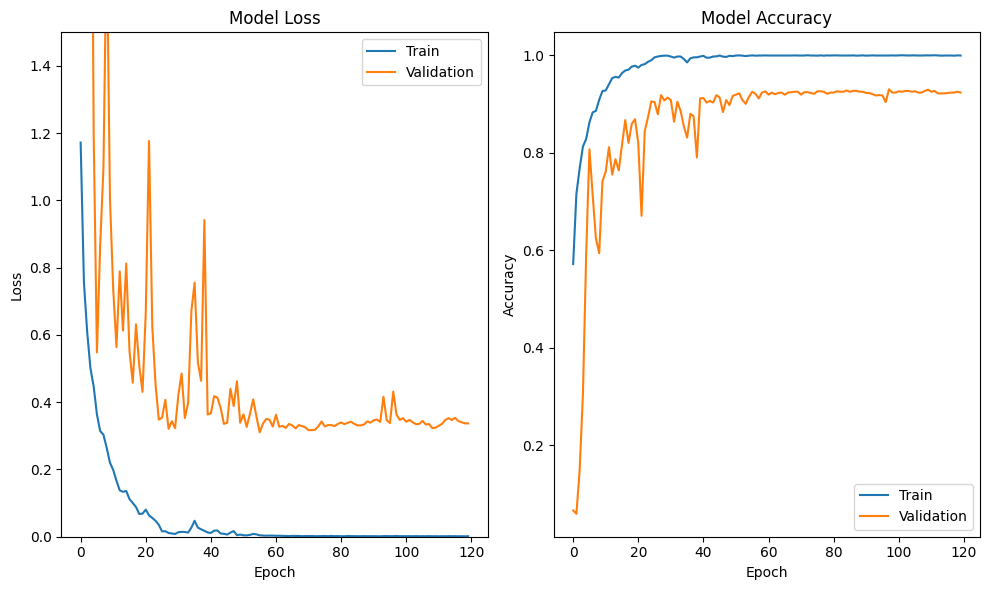

Testing Last Model: Apple13-2Path5-LAB-m4-1.0
37/37 [==============================] - 1s 29ms/step - loss: 0.2931 - accuracy: 0.9288
loss 0.2930919826030731
acc 0.9288135766983032
Best Model Results: Apple13-2Path5-LAB-m4-1.0
37/37 [==============================] - 2s 29ms/step - loss: 0.3316 - accuracy: 0.9203
loss 0.3315828740596771
acc 0.9203389883041382
Finished: Apple13-2Path5-LAB-m4-1.0


In [18]:
for l_ratio in [0.0,0.25,0.50,0.75,1.0]:
        
        basefilename = 'Apple13-2Path5-LAB-m4-' + str(l_ratio)
        print('Running: '+basefilename)
          
        model = two_path5_inception_v3(
            include_top=True,
            weights=None,
            input_tensor=None,
            input_shape=(224,224,3),
            two_paths=True,    
            pooling='max',
            classes=number_of_classes,
            l_ratio=l_ratio,
            ab_ratio=(1.0-l_ratio),
            max_mix_idx=4
        )
        
        model.compile(
            loss='categorical_crossentropy',
            optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
            metrics=['accuracy']
        )
          
        best_result_file_name = basefilename+'-best_result.hdf5'
          
        save_best = tf.keras.callbacks.ModelCheckpoint(
            filepath=best_result_file_name, 
            monitor=monitor, 
            verbose=True,
            save_best_only=True,
            save_weights_only=False, 
            mode='max',
            save_freq='epoch'
        )
          
        history = model.fit(
            train_x,
            train_y, 
            epochs=120, 
            batch_size=batch_size,
            validation_data=(val_x,val_y),
            callbacks=[save_best],
            class_weight=classweight,
            workers=multiprocessing.cpu_count()
        )        
        
        history_filename = basefilename +'-History.png'
        plot_history(history_filename)
        
        print('Testing Last Model: '+basefilename)
          
        evaluated = model.evaluate(test_x,test_y)
          
        for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
            print(name,metric)
            
        print('Best Model Results: '+basefilename)
          
        model = tf.keras.models.load_model(
            best_result_file_name,
            custom_objects={'CopyChannels': cai.layers.CopyChannels}
        )
          
        evaluated = model.evaluate(test_x,test_y)
          
        # cai.models.save_model(model, basefilename)
          
        for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
            print(name,metric)
        
        print('Finished: '+basefilename)

# Calcutale F1 and other metrics

In [11]:
for l_ratio in [0.0,0.25,0.50,0.75,1.0]:
    
    basefilename = 'Apple13-2Path5-LAB-m4-' + str(l_ratio)
    
    best_result_file_name = basefilename+'-best_result.hdf5'
    
    print('Best Model Results: '+basefilename)
    
    model = tf.keras.models.load_model(
        best_result_file_name,
        custom_objects={'CopyChannels': cai.layers.CopyChannels}
    )
    
    pred_y = model.predict(test_x)
    #         print("Predicted Shape:", pred_y.shape)
    pred_classes_y = np.array(list(np.argmax(pred_y, axis=1)))
    test_classes_y = np.array(list(np.argmax(test_y, axis=1)))
    #         print("Pred classes shape:",pred_classes_y.shape)
    #         print("Test classes shape:",test_classes_y.shape)
    report = classification_report(test_classes_y, pred_classes_y, digits=4)
    print(report)

Best Model Results: Apple13-2Path5-LAB-m4-0.0
37/37 [==============================] - 2s 26ms/step
              precision    recall  f1-score   support

           0     0.8333    0.8333    0.8333        84
           1     1.0000    1.0000    1.0000       101
           2     0.9881    1.0000    0.9940        83
           3     0.9709    1.0000    0.9852       100
           4     0.9529    0.9759    0.9643        83
           5     0.9884    0.9659    0.9770        88
           6     0.9796    0.9412    0.9600       102
           7     0.8462    0.8088    0.8271        68
           8     1.0000    0.9901    0.9950       101
           9     1.0000    1.0000    1.0000        89
          10     0.9452    0.9200    0.9324        75
          11     0.9434    0.9804    0.9615       102
          12     0.9811    1.0000    0.9905       104

    accuracy                         0.9602      1180
   macro avg     0.9561    0.9550    0.9554      1180
weighted avg     0.9600    0.9602 

# Confusion Matrix

Best Model Results: Apple13-2Path5-LAB-m4-0.0
37/37 [==============================] - 2s 26ms/step


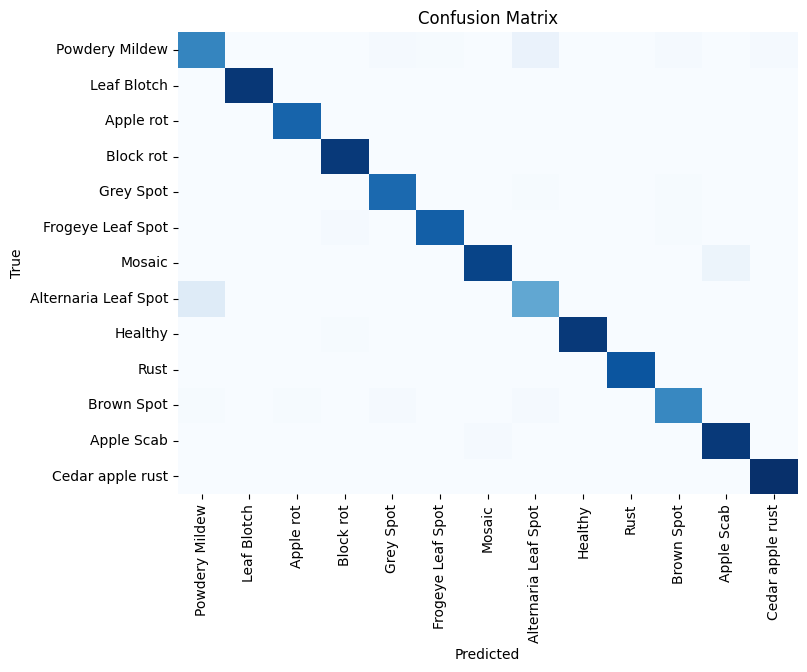

Best Model Results: Apple13-2Path5-LAB-m4-0.25
37/37 [==============================] - 2s 27ms/step


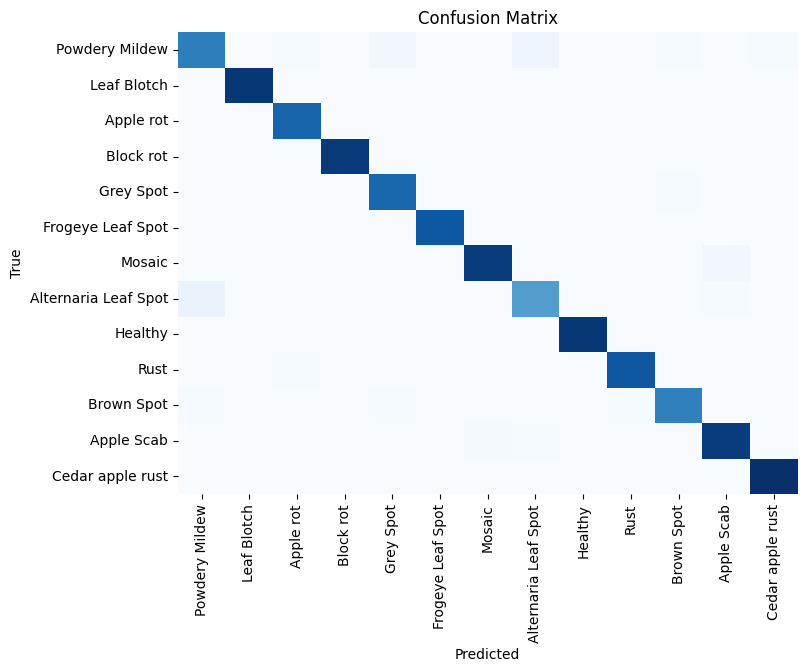

Best Model Results: Apple13-2Path5-LAB-m4-0.5
37/37 [==============================] - 2s 26ms/step


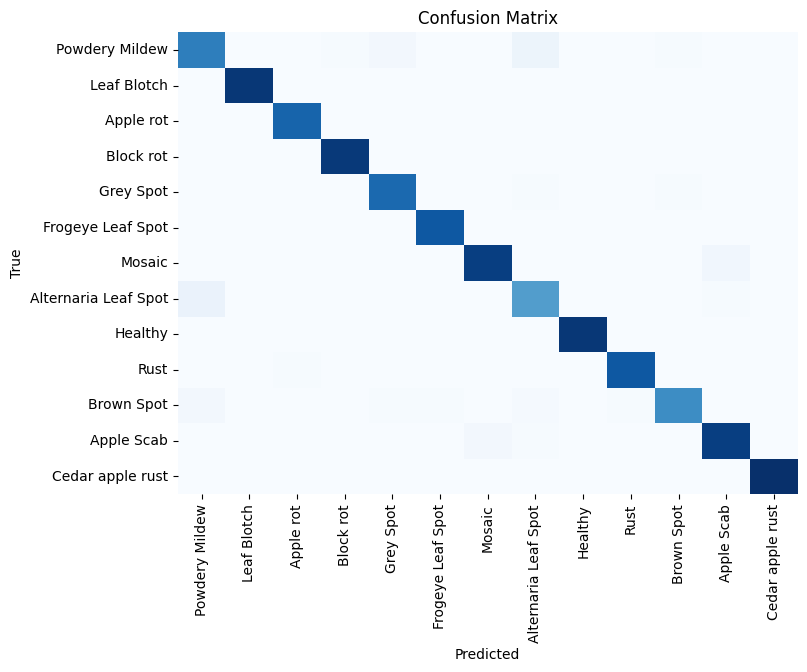

Best Model Results: Apple13-2Path5-LAB-m4-0.75
37/37 [==============================] - 2s 27ms/step


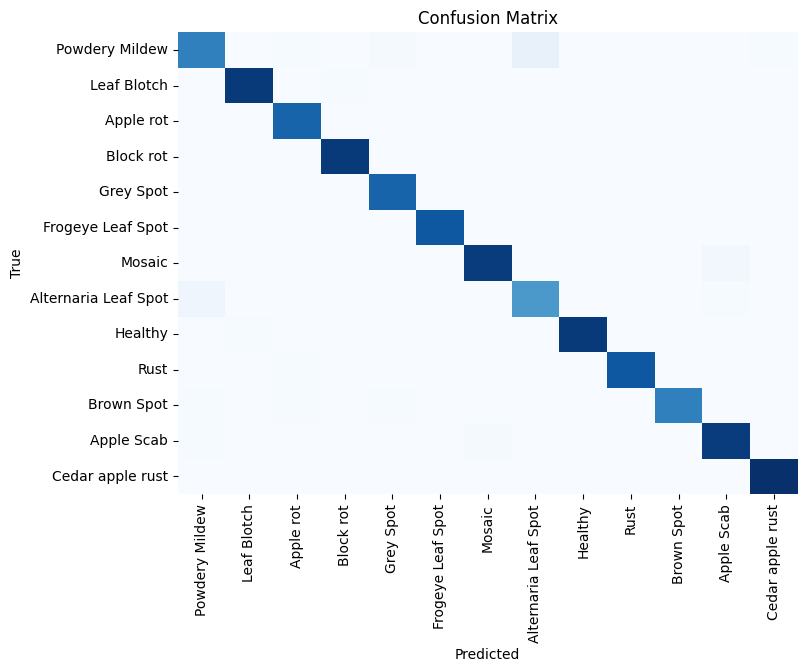

Best Model Results: Apple13-2Path5-LAB-m4-1.0
37/37 [==============================] - 2s 27ms/step


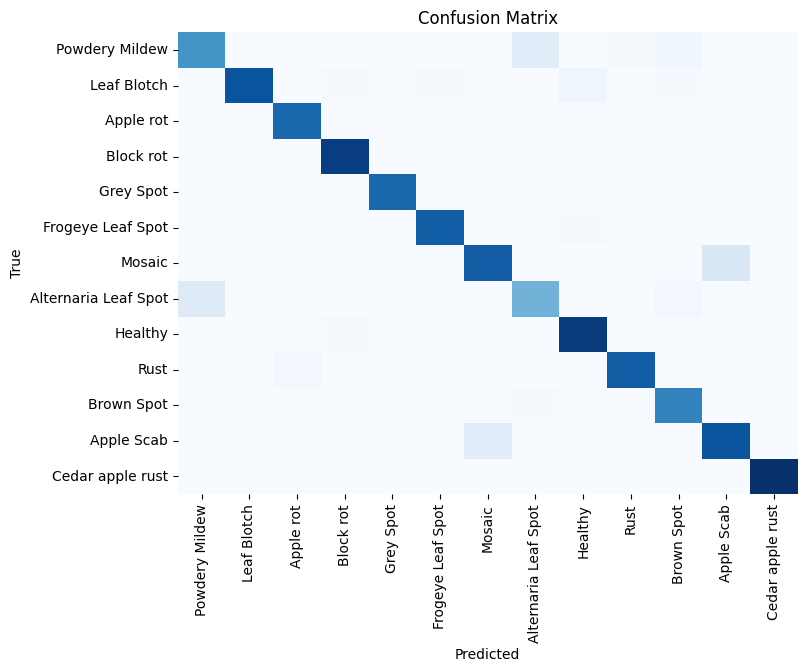

In [12]:
for l_ratio in [0.0,0.25,0.50,0.75,1.0]:
    
    basefilename = 'Apple13-2Path5-LAB-m4-' + str(l_ratio)
     
    best_result_file_name = basefilename+'-best_result.hdf5'          

    print('Best Model Results: '+basefilename)          
    model = tf.keras.models.load_model(
        best_result_file_name,
        custom_objects={'CopyChannels': cai.layers.CopyChannels}
    )

    # Make predictions
    y_pred_prob = model.predict(test_x)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Create the confusion matrix
    cm = confusion_matrix(np.argmax(test_y, axis=1), y_pred)

    # Visualize the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False,
                xticklabels=label_of_classes, yticklabels=label_of_classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    figfilename = basefilename+'-CF.png'
    plt.savefig(figfilename, bbox_inches='tight')

    plt.show()